In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv("diabetes.csv")

In [2]:
# Hàm khởi tạo model cố định
def get_model():
    return MLPClassifier(
        hidden_layer_sizes=(16, 8), 
        max_iter=1000, 
        random_state=42, 
        learning_rate_init=0.01
    )

results = {}
loss_curves = {}
convergence_speeds = {}

In [3]:
na_count = df.isna().sum()
print(na_count[na_count > 0])

Series([], dtype: int64)


In [4]:
zeros_count = (df == 0).sum()
print(zeros_count[zeros_count > 0])

Pregnancies      111
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
Outcome          500
dtype: int64


In [5]:
# --- Thực hiện các kịch bản ---
scenarios = ['No Preprocessing', 'Normalization', 'Standardization', 'Outlier Removal', 'Imputation']

for scenario in scenarios:
    df_temp = df.copy()
    
    if scenario == 'No Preprocessing':
        X, y = df_temp.drop('Outcome', axis=1), df_temp['Outcome']
        
    elif scenario == 'Normalization':
        X = MinMaxScaler().fit_transform(df_temp.drop('Outcome', axis=1))
        y = df_temp['Outcome']
        
    elif scenario == 'Standardization':
        X = StandardScaler().fit_transform(df_temp.drop('Outcome', axis=1))
        y = df_temp['Outcome']
        
    elif scenario == 'Outlier Removal':
        X_raw = df_temp.drop('Outcome', axis=1)
        z_scores = np.abs((X_raw - X_raw.mean()) / X_raw.std())
        # Chỉ giữ lại các hàng có tất cả các cột z_score < 3
        df_clean = df_temp[(z_scores < 3).all(axis=1)]
        X = StandardScaler().fit_transform(df_clean.drop('Outcome', axis=1))
        y = df_clean['Outcome']
        
    elif scenario == 'Imputation':
        # Các cột thường bị thiếu giá trị (hiển thị là 0)
        cols_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
        for col in cols_fix:
            df_temp[col] = df_temp[col].replace(0, df_temp[col].median())
        X = StandardScaler().fit_transform(df_temp.drop('Outcome', axis=1))
        y = df_temp['Outcome']

    # Chia tập dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Huấn luyện
    mlp = get_model()
    mlp.fit(X_train, y_train)
    
    # Lưu kết quả
    results[scenario] = accuracy_score(y_test, mlp.predict(X_test))
    loss_curves[scenario] = mlp.loss_curve_
    convergence_speeds[scenario] = mlp.n_iter_

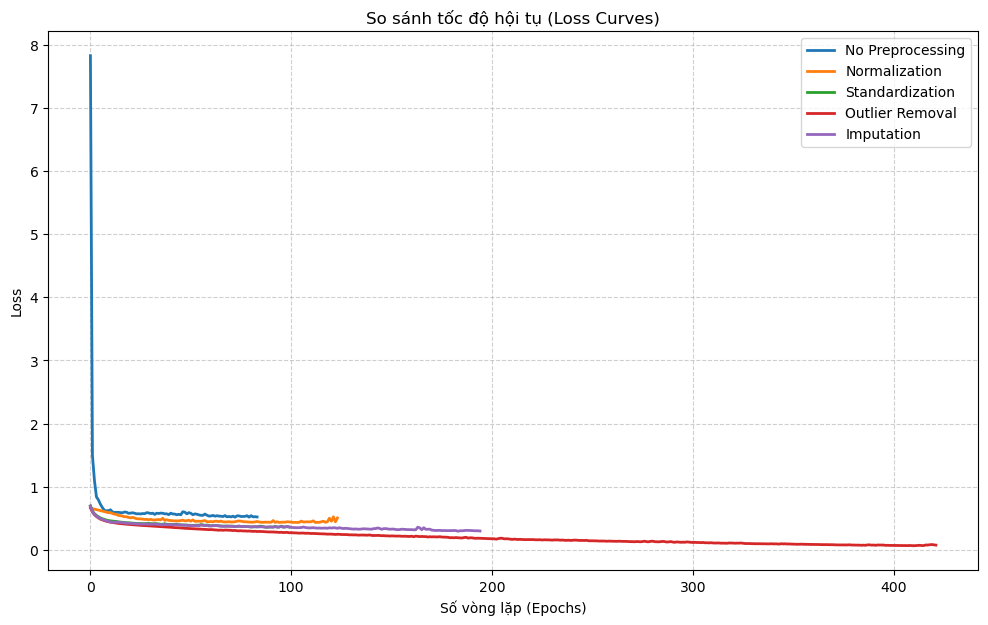

In [6]:
# --- 2. Vẽ đồ thị Loss Curves ---
plt.figure(figsize=(12, 7))
for label, curve in loss_curves.items():
    plt.plot(curve, label=label, linewidth=2)
plt.title('So sánh tốc độ hội tụ (Loss Curves)')
plt.xlabel('Số vòng lặp (Epochs)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [7]:
# --- 3. Tạo Performance Comparison Table ---
performance_data = []
for s in scenarios:
    performance_data.append({
        'Phương pháp': s,
        'Độ chính xác (Accuracy %)': round(results[s] * 100, 2),
        'Số vòng lặp hội tụ': convergence_speeds[s],
        'Loss cuối cùng': round(loss_curves[s][-1], 5)
    })

perf_df = pd.DataFrame(performance_data)
print("\n=== PERFORMANCE COMPARISON TABLE ===")
print(perf_df.to_string(index=False))


=== PERFORMANCE COMPARISON TABLE ===
     Phương pháp  Độ chính xác (Accuracy %)  Số vòng lặp hội tụ  Loss cuối cùng
No Preprocessing                      77.27                  84         0.51893
   Normalization                      76.62                 124         0.50319
 Standardization                      76.62                 100         0.35619
 Outlier Removal                      66.67                 422         0.07270
      Imputation                      73.38                 195         0.29614
